In [38]:
import xarray as xr
import matplotlib.pyplot as plt
from stompy.grid import unstructured_grid
import numpy as np
%matplotlib notebook

In [7]:
# Trying to better understand the z-layer output
run_dir='run_salt_20160520-v05'
out_dir=run_dir+"/DFM_OUTPUT_flowfm"

In [48]:
# look at proc 3 and 15, where the inflows are
ds=xr.open_dataset(out_dir+"/flowfm_0015_map.nc")

In [37]:
ds

<xarray.Dataset>
Dimensions:                      (laydim: 10, nBndLink: 209, nFlowElem: 5063, nFlowElemContourPts: 4, nFlowLink: 7879, nFlowLinkPts: 2, nNetElem: 5063, nNetElemMaxNode: 4, nNetLink: 8081, nNetLinkContourPts: 4, nNetLinkPts: 2, nNetNode: 3019, nmesh2d_EnclosureInstance: 1, nmesh2d_EnclosureParts: 1, nmesh2d_EnclosurePoints: 182, time: 94, wdim: 11)
Coordinates:
    NetNode_x                    (nNetNode) float64 ...
    NetNode_y                    (nNetNode) float64 ...
    FlowElem_xcc                 (nFlowElem) float64 ...
    FlowElem_ycc                 (nFlowElem) float64 ...
    FlowLink_xu                  (nFlowLink) float64 ...
    FlowLink_yu                  (nFlowLink) float64 ...
  * time                         (time) datetime64[ns] 2016-05-20 ... 2016-06...
Dimensions without coordinates: laydim, nBndLink, nFlowElem, nFlowElemContourPts, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkContourPts, nNetLinkPts, nNetNode, nmesh2d_EnclosureInstance, nmesh2d_EnclosureParts, nmesh2d_EnclosurePoints, wdim
Data variables:
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 ...
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enclosure_container   float32 ...
    Mesh2D                       int32 ...
    projected_coordinate_system  int32 ...
    NetNode_z                    (nNetNode) float64 ...
    NetLink                      (nNetLink, nNetLinkPts) int32 ...
    NetLinkType                  (nNetLink) int32 ...
    NetElemNode                  (nNetElem, nNetElemMaxNode) float64 ...
    NetElemLink                  (nNetElem, nNetElemMaxNode) int32 ...
    NetLinkContour_x             (nNetLink, nNetLinkContourPts) float64 ...
    NetLinkContour_y             (nNetLink, nNetLinkContourPts) float64 ...
    NetLink_xu                   (nNetLink) float64 ...
    NetLink_yu                   (nNetLink) float64 ...
    BndLink                      (nBndLink) int32 ...
    FlowElem_zcc                 (nFlowElem) float64 ...
    FlowElem_bac                 (nFlowElem) float64 ...
    FlowElem_xzw                 (nFlowElem) float64 ...
    FlowElem_yzw                 (nFlowElem) float64 ...
    FlowElemContour_x            (nFlowElem, nFlowElemContourPts) float64 ...
    FlowElemContour_y            (nFlowElem, nFlowElemContourPts) float64 ...
    FlowElem_bl                  (nFlowElem) float64 ...
    ElemLink                     (nNetLink, nNetLinkPts) int32 ...
    FlowLink                     (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                 (nFlowLink) int32 ...
    FlowLink_lonu                (nFlowLink) float64 ...
    FlowLink_latu                (nFlowLink) float64 ...
    FlowElemDomain               (nFlowElem) int32 ...
    FlowLinkDomain               (nFlowLink) int32 ...
    FlowElemGlobalNr             (nFlowElem) int32 ...
    LayCoord_cc                  (laydim) float64 ...
    LayCoord_w                   (wdim) float64 ...
    timestep                     (time) timedelta64[ns] ...
    s1                           (time, nFlowElem) float64 ...
    waterdepth                   (time, nFlowElem) float64 ...
    numlimdt                     (time, nFlowElem) float64 ...
    taus                         (time, nFlowElem) float64 ...
    unorm                        (time, nFlowLink, laydim) float64 ...
    u0                           (time, nFlowLink, laydim) float64 ...
    q1                           (time, nFlowLink, laydim) float64 ...
    viu                          (time, nFlowLink, laydim) float64 ...
    diu                          (time, nFlowLink, laydim) float64 ...
    ucz                          (time, nFlowElem, laydim) float64 ...
    ucxa                         (time, n

In [12]:
# Layer information in there:
# ds.dims['laydim'] is 10
# wdim is 11
# LayCoord_{cc,w} are meaningless.
ds['LayCoord_w']

<xarray.DataArray 'LayCoord_w' (wdim: 11)>
array([9.96921e+36, 9.96921e+36, 9.96921e+36, 9.96921e+36, 9.96921e+36,
       9.96921e+36, 9.96921e+36, 9.96921e+36, 9.96921e+36, 9.96921e+36,
       9.96921e+36])
Dimensions without coordinates: wdim
Attributes:
    standard_name:  
    long_name:      z layer coordinate at vertical interface
    positive:       up
    units:          m

In [28]:
# ucz is a layer-centered vertical velocity.
# Take a sample element at the last time step:
# layers start at bed
t=-1
if 0==np.sum(np.isnan(ds['ucz'].isel(laydim=9,time=t).values)):
    print("All top layer cells have finite ucz")
if 0==np.sum(np.isnan(ds['ww1'].isel(wdim=10,time=t).values)):
    print("All top layer cells have finite surface ww1")
if 0==np.sum(np.isnan(ds['ww1'].isel(wdim=9,time=t).values)):
    print("All top layer cells have finite sub-surface ww1")
if 0<np.sum(np.isnan(ds['ww1'].isel(wdim=8,time=t).values)):
    print("Some cells have nan sub-surface ww1")
    
    

elt=10
print(ds['ucz'].isel(time=t,nFlowElem=elt).values)
print(ds['ww1'].isel(time=t,nFlowElem=elt).values)

[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan 1.71407016e-05]
[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan 0.00000000e+00 2.27844134e-05]
All top layer cells have finite ucz
All top layer cells have finite surface ww1
All top layer cells have finite sub-surface ww1
Some cells have nan sub-surface ww1


In [39]:
nlayers=np.isfinite(ds['ucz'].isel(time=t)).sum(dim='laydim')
print(f"Number of layers (w/finite ucz) ranges from {nlayers.values.min()} to {nlayers.values.max()}")

Number of layers (w/finite ucz) ranges from 1 to 10


In [35]:
for proc in range(16):
    ds_proc=xr.open_dataset(out_dir+f"/flowfm_{proc:04d}_map.nc")
    nlayers=np.isfinite(ds_proc['ucz'].isel(time=t)).sum(dim='laydim')
    print(f"[p={proc:02d}] Number of layers (w/finite ucz) ranges from {nlayers.values.min()} to {nlayers.values.max()}")
    ds_proc.close()

# proc 3 and 15 have cells with 10 layers.


[p=00] Number of layers (w/finite ucz) ranges from 1 to 6
[p=01] Number of layers (w/finite ucz) ranges from 1 to 5
[p=02] Number of layers (w/finite ucz) ranges from 1 to 1
[p=03] Number of layers (w/finite ucz) ranges from 1 to 10
[p=04] Number of layers (w/finite ucz) ranges from 1 to 5
[p=05] Number of layers (w/finite ucz) ranges from 1 to 3
[p=06] Number of layers (w/finite ucz) ranges from 1 to 3
[p=07] Number of layers (w/finite ucz) ranges from 1 to 3
[p=08] Number of layers (w/finite ucz) ranges from 1 to 5
[p=09] Number of layers (w/finite ucz) ranges from 1 to 6
[p=10] Number of layers (w/finite ucz) ranges from 1 to 6
[p=11] Number of layers (w/finite ucz) ranges from 1 to 5
[p=12] Number of layers (w/finite ucz) ranges from 1 to 8
[p=13] Number of layers (w/finite ucz) ranges from 1 to 3
[p=14] Number of layers (w/finite ucz) ranges from 1 to 7
[p=15] Number of layers (w/finite ucz) ranges from 1 to 10


In [49]:
g=unstructured_grid.UnstructuredGrid.read_ugrid(ds)

In [42]:
ds # check out NetNode_z, FlowElem_zcc, FlowElem_bl

<xarray.Dataset>
Dimensions:                      (laydim: 10, nBndLink: 209, nFlowElem: 5063, nFlowElemContourPts: 4, nFlowLink: 7879, nFlowLinkPts: 2, nNetElem: 5063, nNetElemMaxNode: 4, nNetLink: 8081, nNetLinkContourPts: 4, nNetLinkPts: 2, nNetNode: 3019, nmesh2d_EnclosureInstance: 1, nmesh2d_EnclosureParts: 1, nmesh2d_EnclosurePoints: 182, time: 94, wdim: 11)
Coordinates:
    NetNode_x                    (nNetNode) float64 5.53e+05 ... 5.531e+05
    NetNode_y                    (nNetNode) float64 4.123e+06 ... 4.123e+06
    FlowElem_xcc                 (nFlowElem) float64 5.536e+05 ... 5.53e+05
    FlowElem_ycc                 (nFlowElem) float64 4.123e+06 ... 4.123e+06
    FlowLink_xu                  (nFlowLink) float64 5.536e+05 ... 5.536e+05
    FlowLink_yu                  (nFlowLink) float64 4.123e+06 ... 4.123e+06
  * time                         (time) datetime64[ns] 2016-05-20 ... 2016-06...
Dimensions without coordinates: laydim, nBndLink, nFlowElem, nFlowElemContourPts, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkContourPts, nNetLinkPts, nNetNode, nmesh2d_EnclosureInstance, nmesh2d_EnclosureParts, nmesh2d_EnclosurePoints, wdim
Data variables:
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 5.536e+05 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 4.123e+06 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 182
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 182
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 0
    mesh2d_enclosure_container   float32 9.969e+36
    Mesh2D                       int32 -2147483647
    projected_coordinate_system  int32 -2147483647
    NetNode_z                    (nNetNode) float64 2.601 2.031 ... 3.251 2.884
    NetLink                      (nNetLink, nNetLinkPts) int32 2133 1967 ... 921
    NetLinkType                  (nNetLink) int32 2 2 2 2 2 2 2 ... 2 2 2 2 2 2
    NetElemNode                  (nNetElem, nNetElemMaxNode) float64 1.967e+0...
    NetElemLink                  (nNetElem, nNetElemMaxNode) int32 2 ... -214...
    NetLinkContour_x             (nNetLink, nNetLinkContourPts) float64 5.536...
    NetLinkContour_y             (nNetLink, nNetLinkContourPts) float64 4.123...
    NetLink_xu                   (nNetLink) float64 5.536e+05 ... 5.53e+05
    NetLink_yu                   (nNetLink) float64 4.123e+06 ... 4.123e+06
    BndLink                      (nBndLink) int32 1 2 4 6 ... 8069 8074 8079
    FlowElem_zcc                 (nFlowElem) float64 -4.465 -4.465 ... -2.335
    FlowElem_bac                 (nFlowElem) float64 111.2 122.6 ... 15.38 16.94
    FlowElem_xzw                 (nFlowElem) float64 5.536e+05 ... 5.53e+05
    FlowElem_yzw                 (nFlowElem) float64 4.123e+06 ... 4.123e+06
    FlowElemContour_x            (nFlowElem, nFlowElemContourPts) float64 5.5...
    FlowElemContour_y            (nFlowElem, nFlowElemContourPts) float64 4.1...
    FlowElem_bl                  (nFlowElem) float64 4.465 4.465 ... 2.335 2.335
    ElemLink                     (nNetLink, nNetLinkPts) int32 1 0 ... 5063 5062
    FlowLink                     (nFlowLink, nFlowLinkPts) int32 1 4 ... 1259
    FlowLinkType                 (nFlowLink) int32 2 2 2 2 2 2 2 ... 2 2 2 2 2 2
    FlowLink_lonu                (nFlowLink) float64 9.969e+36 ... 9.969e+36
    FlowLink_latu                (nFlowLink) float64 9.969e+36 ... 9.969e+36
    FlowElemDomain               (nFlowElem) int32 15 15 15 15 15 ... 1 1 3 1 1
    FlowLinkDomain               (nFlowLink) int32 3 3 3 3 3 3 3 ... 3 3 3 3 3 3
    FlowElemGlobalNr             (nFlowElem) int32 40817 41654 ... 11486 11485
    LayCoord_cc                  (laydim) float64 9.969e+36 ... 9.969e+36
    LayCoord_w                   (wdim) float64 9.969e+36 ... 9.969e+36
    timestep                     (time) timedelta64[ns] 00:00:01 ... 00:00:04...
    s1                           (time, nFlowElem) float64 ...
    w

<IPython.core.display.Javascript object>


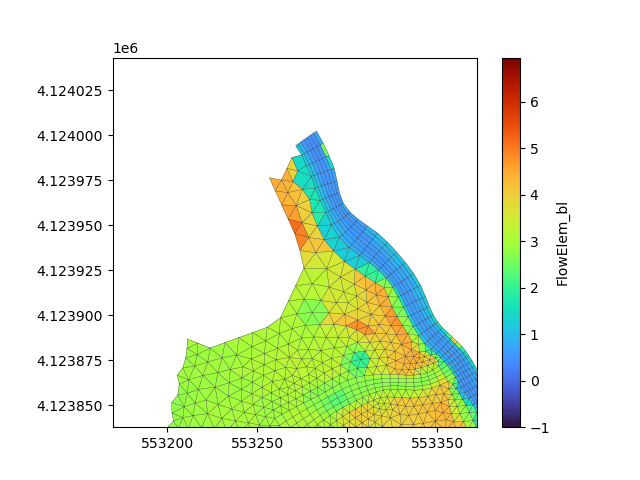

In [50]:
plt.figure()
g.plot_edges(lw=0.2,color='k')
v='FlowElem_bl'
ccoll=g.plot_cells(values=ds[v].values,cmap='turbo')
plt.colorbar(ccoll,label=v)